# Task2:机器学习用于真实时间序列预测

## 数据导入并绘制序列

In [1]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import random
torch.set_default_tensor_type(torch.DoubleTensor)

In [2]:
# 数据导入
X_train = np.load('exp3data/SelfRegulationSCP1/X_train.npy')
y_train = np.load('exp3data/SelfRegulationSCP1/y_train.npy')
X_test = np.load('exp3data/SelfRegulationSCP1/X_test.npy')
y_test = np.load('exp3data/SelfRegulationSCP1/y_test.npy')

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((268, 896, 6), (268, 1), (293, 896, 6), (293, 1))

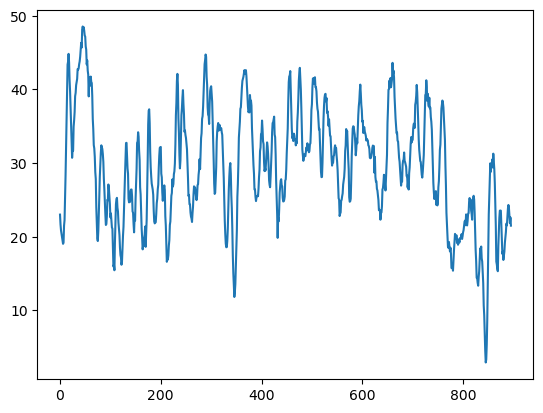

In [3]:
plt.plot(X_train[0,:,0])

## 特征提取

In [4]:
from torch.utils.data import TensorDataset, DataLoader
y_train = torch.tensor(y_train, dtype=torch.double)
y_test = torch.tensor(y_test, dtype=torch.double)
print(y_train.shape, y_test.shape)

torch.Size([268, 1]) torch.Size([293, 1])


### 提取时域特征

#### 均值

In [5]:
# 提取均值——针对每个通道进行提取
X_train_mean = torch.tensor(X_train.mean(axis=2),dtype=torch.double)
X_test_mean = torch.tensor(X_test.mean(axis=2),dtype=torch.double)

train_dataset = TensorDataset(X_train_mean, y_train)
data_loader_mean = DataLoader(train_dataset, batch_size=1, shuffle=False)

X_train_mean.shape, X_test_mean.shape

(torch.Size([268, 896]), torch.Size([293, 896]))

#### 能量

In [7]:
# 提取能量——针对每个通道进行提取
X_train_energy = torch.tensor(np.sum(X_train**2, axis=2), dtype=torch.double)
X_test_energy = torch.tensor(np.sum(X_test**2, axis=2), dtype=torch.double)

train_dataset = TensorDataset(X_train_energy, y_train)
data_loader_energy = DataLoader(train_dataset, batch_size=1, shuffle=False)

X_train_energy.shape, X_test_energy.shape


(torch.Size([268, 896]), torch.Size([293, 896]))

### 提取熵类特征

In [8]:
# 提取近似熵
import antropy

# 对每个样本的每一个通道计算近似熵
X_train_apen, X_test_apen = [], []

for channel in range(X_train.shape[2]):
    for sample in range(X_train.shape[0]):
        X_train_apen.append(antropy.app_entropy(X_train[sample,:,channel], order=2, metric='chebyshev'))

for channel in range(X_test.shape[2]):
    for sample in range(X_test.shape[0]):
        X_test_apen.append(antropy.app_entropy(X_test[sample,:,channel], order=2, metric='chebyshev'))
        
X_train_apen = np.array(X_train_apen).reshape(X_train.shape[0], X_train.shape[2])
X_test_apen = np.array(X_test_apen).reshape(X_test.shape[0], X_test.shape[2])
X_train_apen = torch.tensor(X_train_apen, dtype=torch.double)
X_test_apen = torch.tensor(X_test_apen, dtype=torch.double)

train_dataset = TensorDataset(X_train_apen, y_train)
data_loader_apen = DataLoader(train_dataset, batch_size=1, shuffle=False)

X_train_apen.shape, X_test_apen.shape

(torch.Size([268, 6]), torch.Size([293, 6]))

### 提取频域特征

In [32]:
import yasa
import warnings
warnings.filterwarnings("ignore")

sampling_rate = 256  # 采样率

# 将数据从 (268, 896, 6) 转换为 (268, 6, 896)
# 即将时间点和通道维度进行交换
X_train_trans = np.transpose(X_train, (0, 2, 1))
X_test_trans = np.transpose(X_test, (0, 2, 1))

# 使用 YASA 的 bandpower 函数计算频带能量
# 从前到后分别为 Delta, Theta, Alpha, Beta, Gamma
bands = [(0.5, 4, 'Delta'), (4, 8, 'Theta'), (8, 13, 'Alpha'), (13, 30, 'Beta'), (30, 100, 'Gamma')]
train_bandpower_features, test_handpower_features = [], []
# 遍历每个样本提取频带能量
for sample in range(X_train_trans.shape[0]):
    single_sample = X_train_trans[sample, :, :]
    sample_bandpower = yasa.bandpower(single_sample, sf=sampling_rate, ch_names=None, bands=bands).loc[:, 'Delta':'FreqRes']
    sample_bandpower.apply(pd.to_numeric)
    train_bandpower_features.append(sample_bandpower)
train_bandpower_features = np.array([df.values for df in train_bandpower_features])
  
for sample in range(X_test_trans.shape[0]):
    single_sample = X_test_trans[sample, :, :]
    sample_bandpower = yasa.bandpower(single_sample, sf=sampling_rate, ch_names=None, bands=bands).loc[:, 'Delta':'FreqRes']
    sample_bandpower.apply(pd.to_numeric)
    test_handpower_features.append(sample_bandpower)
test_handpower_features = np.array([df.values for df in test_handpower_features])

train_bandpower_features.shape, test_handpower_features.shape

((268, 6, 7), (293, 6, 7))

In [69]:
# 把后两维特征进行融合
X_train_bandpower = train_bandpower_features.reshape(train_bandpower_features.shape[0], -1)
X_test_bandpower = test_handpower_features.reshape(test_handpower_features.shape[0], -1)

    
X_train_bandpower = torch.tensor(X_train_bandpower, dtype=torch.double)
X_test_bandpower = torch.tensor(X_test_bandpower, dtype=torch.double)

train_dataset = TensorDataset(X_train_bandpower, y_train)
data_loader_bandpower = DataLoader(train_dataset, batch_size=1, shuffle=False)


X_train_bandpower.shape, X_test_bandpower.shape

(torch.Size([268, 42]), torch.Size([293, 42]))

### 提取时频特征

In [37]:
import pywt
from scipy.stats import entropy

def calculate_dwt_features(eeg_data, wavelet='db1', level=3):
    # 计算DWT
    coeffs = pywt.wavedec(eeg_data, wavelet, level=level)
    # 初始化特征字典
    features = []
    # 计算每个小波分量的特征
    for i, coeff in enumerate(coeffs):
        # 计算能量
        energy = np.sum(np.abs(coeff) ** 2)
        features.append(energy)

        # 计算Shannon熵
        prob_dist = np.abs(coeff) / np.sum(np.abs(coeff))
        shannon_entropy = entropy(prob_dist, base=2)
        features.append(shannon_entropy)
    return features

def calculate_variable_TF(sample_data):
    num_channels = sample_data.shape[0]
    TF_values = []

    for i in range(num_channels):
        features=calculate_dwt_features(sample_data[i])
        TF_values+=features

    return TF_values

In [68]:
TF_train = calculate_variable_TF(X_train)
TF_train = np.array(TF_train).reshape(X_train.shape[0], -1)
TF_test = calculate_variable_TF(X_test)
TF_test = np.array(TF_test).reshape(X_test.shape[0], -1)

TF_train.shape, TF_test.shape

((268, 8), (293, 8))

### 神经网络

#### 构建前馈神经网络

In [71]:
# 实现FlattenLayer层
class FlattenLayer(nn.Module):
    def __init__(self):
        super(FlattenLayer, self).__init__()
        
    def forward(self, x): # x shape: (batch, *, *, ...)
        # print('x.view 之前' ,x.shape)
        return x.view(x.shape[0], -1)

#### 定义训练函数

In [72]:
# 参数初始化
def init_net(net):
    for params in net.parameters():
        nn.init.normal_(params, mean=0, std=0.01)

In [73]:
def train(data_loader, X_train, y_train, X_test, y_test, net):
    train_loss = []
    test_loss = []

    loss_fn = nn.BCELoss()
    lr=0.01
    num_epochs=150
    optimizer=torch.optim.Adam(net.parameters(), lr=lr)
    
    # 模型训练
    for epoch in range(num_epochs):  # 外循环训练一轮
        train_l, test_l = 0.0, 0.0
        for X, y in data_loader:
            # print('X shape:', X.shape)
            y_hat = net(X)
            y_hat = y_hat.view(y.shape)
            
            # print('y_hat shape:', y_hat.shape)
            # print('y shape:', y.shape)
            
            l = loss_fn(y_hat, y).sum()
            # 梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            # 反向传播
            l.backward()
            # 更新参数
            optimizer.step()
            
        # 该轮训练结束后，计算训练集和测试集的损失（每个样本的平均损失）      
        train_l = loss_fn(net(X_train), y_train).mean().item()
        test_l = loss_fn(net(X_test), y_test).mean().item()
        
        train_loss.append(train_l)
        test_loss.append(test_l)
        print('epoch %d, train loss %f, test loss %f' % (epoch, train_l, test_l))
        
    return train_loss, test_loss

#### 时域特征——均值

In [245]:
# 定义模型输入、输出、隐藏层维度
num_inputs, num_outputs, num_hiddens = 896, 1, 128

# 定义模型
net = nn.Sequential(
    FlattenLayer(),
    nn.Linear(num_inputs, num_hiddens),
    nn.ReLU(),
    nn.Linear(num_hiddens, num_outputs),
    nn.Sigmoid()
)

训练模型

In [ ]:
train_loss, test_loss = train(data_loader_mean, X_train_mean, y_train, X_test_mean, y_test, net)

绘制损失函数Loss曲线

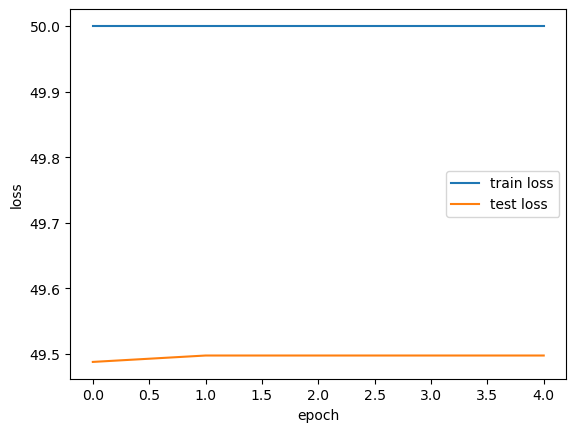

In [202]:
x = np.arange(5)
plt.plot(x, train_loss, label='train loss', linewidth=1.5)
plt.plot(x, test_loss, label='test loss', linewidth=1.5)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

#### 时域特征——能量

In [203]:
# 定义模型输入、输出、隐藏层维度
num_inputs, num_outputs, num_hiddens = 896, 1, 128

# 定义模型
net = nn.Sequential(
    FlattenLayer(),
    nn.Linear(num_inputs, num_hiddens),
    nn.ReLU(),
    nn.Linear(num_hiddens, num_outputs),
    nn.Sigmoid()
)

训练模型

In [204]:
train_loss, test_loss = train(X_train_energy, y_train, X_test_energy, y_test, net)

epoch 0, train loss 49.626866, test loss 49.829352
epoch 1, train loss 49.626866, test loss 49.829352
epoch 2, train loss 49.626866, test loss 49.829352
epoch 3, train loss 49.626866, test loss 49.829352
epoch 4, train loss 49.626866, test loss 49.829352


绘制损失函数Loss曲线

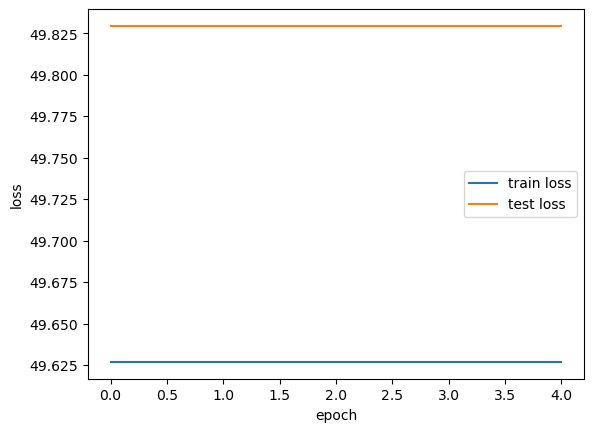

In [205]:
x = np.arange(5)
plt.plot(x, train_loss, label='train loss', linewidth=1.5)
plt.plot(x, test_loss, label='test loss', linewidth=1.5)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

#### 熵类特征

In [82]:
# 定义模型输入、输出、隐藏层维度
num_inputs, num_outputs, num_hiddens = 6, 1, 16

# 定义模型
net = nn.Sequential(
    FlattenLayer(),
    nn.Linear(num_inputs, num_hiddens),
    nn.ReLU(),
    nn.Linear(num_hiddens, num_outputs),
    nn.Sigmoid()
)

训练模型

In [83]:
train_loss, test_loss = train(data_loader_apen, X_train_apen, y_train, X_test_apen, y_test, net)

epoch 0, train loss 0.861206, test loss 0.858825
epoch 1, train loss 0.760403, test loss 0.758933
epoch 2, train loss 0.743961, test loss 0.742690
epoch 3, train loss 0.739652, test loss 0.738438
epoch 4, train loss 0.738185, test loss 0.736992
epoch 5, train loss 0.737547, test loss 0.736362
epoch 6, train loss 0.737204, test loss 0.736023
epoch 7, train loss 0.736990, test loss 0.735812
epoch 8, train loss 0.736845, test loss 0.735670
epoch 9, train loss 0.736743, test loss 0.735569
epoch 10, train loss 0.736669, test loss 0.735496
epoch 11, train loss 0.736614, test loss 0.735442
epoch 12, train loss 0.736574, test loss 0.735402
epoch 13, train loss 0.736544, test loss 0.735373
epoch 14, train loss 0.736521, test loss 0.735351
epoch 15, train loss 0.736504, test loss 0.735334
epoch 16, train loss 0.736491, test loss 0.735321
epoch 17, train loss 0.736482, test loss 0.735312
epoch 18, train loss 0.736474, test loss 0.735304
epoch 19, train loss 0.736469, test loss 0.735299
epoch 20, 

绘制损失函数Loss曲线

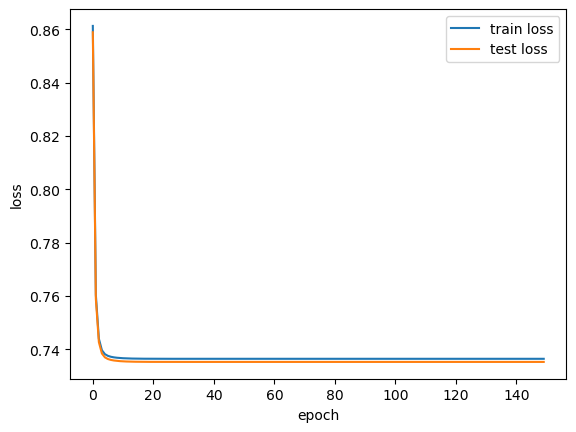

In [84]:
x = np.arange(150)
plt.plot(x, train_loss, label='train loss', linewidth=1.5)
plt.plot(x, test_loss, label='test loss', linewidth=1.5)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

#### 频域特征

In [79]:
# 定义模型输入、输出、隐藏层维度
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 42, 1, 16, 8

# 定义模型
net = nn.Sequential(
    FlattenLayer(),
    nn.Linear(num_inputs, num_hiddens1),
    nn.ReLU(),
    nn.Linear(num_hiddens1, num_hiddens2),
    nn.ReLU(),
    nn.Linear(num_hiddens2, num_outputs),
    nn.Sigmoid()
)

训练模型

In [80]:
train_loss, test_loss = train(data_loader_bandpower, X_train_bandpower, y_train, X_test_bandpower, y_test, net)

epoch 0, train loss 1.646956, test loss 1.640498
epoch 1, train loss 1.164884, test loss 1.160675
epoch 2, train loss 0.937370, test loss 0.934458
epoch 3, train loss 0.849937, test loss 0.847643
epoch 4, train loss 0.806492, test loss 0.804560
epoch 5, train loss 0.777865, test loss 0.776206
epoch 6, train loss 0.758312, test loss 0.756865
epoch 7, train loss 0.746258, test loss 0.744958
epoch 8, train loss 0.740330, test loss 0.739107
epoch 9, train loss 0.738106, test loss 0.736913
epoch 10, train loss 0.737345, test loss 0.736163
epoch 11, train loss 0.737032, test loss 0.735854
epoch 12, train loss 0.736864, test loss 0.735689
epoch 13, train loss 0.736757, test loss 0.735583
epoch 14, train loss 0.736680, test loss 0.735508
epoch 15, train loss 0.736624, test loss 0.735452
epoch 16, train loss 0.736582, test loss 0.735411
epoch 17, train loss 0.736551, test loss 0.735380
epoch 18, train loss 0.736527, test loss 0.735356
epoch 19, train loss 0.736509, test loss 0.735338
epoch 20, 

绘制损失函数Loss曲线

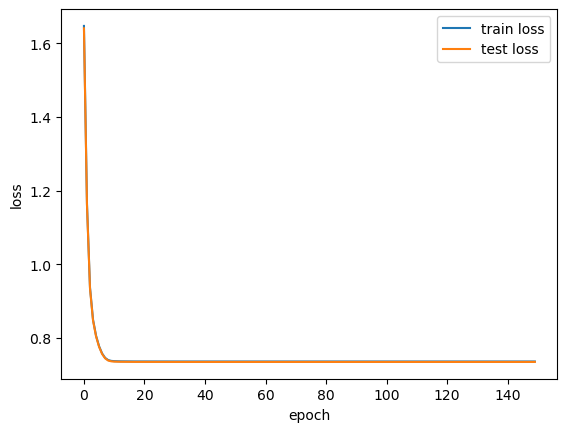

In [81]:
x = np.arange(150)
plt.plot(x, train_loss, label='train loss', linewidth=1.5)
plt.plot(x, test_loss, label='test loss', linewidth=1.5)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

#### 总结

通过将各种特征在3层神经网络上运行，可以得出时域特征的表现最不佳，训练集和测试集的误差居高不下；相比之下，熵类特征和频域特征的表现要好的多，符合正常的模式

### 使用机器学习模型

#### 使用SVC进行分类

##### 时域特征——均值

In [93]:
from sklearn.svm import SVC

model = SVC(kernel='rbf')
# 模型训练
model.fit(X_train_mean, y_train)
# 测试集预测
test_predict = model.predict(X_test_mean)
# 计算bce
bce_loss = nn.BCELoss()
y_test = torch.tensor(y_test, dtype=torch.double).squeeze()
test_predict = torch.tensor(test_predict, dtype=torch.double)
print(y_test.shape, test_predict.shape)
bce = bce_loss(y_test, test_predict)

print('使用SVC模型的测试集最终BCE:', bce.item())

torch.Size([293]) torch.Size([293])
使用SVC模型的测试集最终BCE: 16.040955631399317


##### 时域特征——能量

In [96]:
from sklearn.svm import SVC

model = SVC(kernel='rbf')
# 模型训练
model.fit(X_train_energy, y_train)
# 测试集预测
test_predict = model.predict(X_test_energy)
# 计算bce
bce_loss = nn.BCELoss()
y_test = torch.tensor(y_test, dtype=torch.double).squeeze()
test_predict = torch.tensor(test_predict, dtype=torch.double)
print(y_test.shape, test_predict.shape)
bce = bce_loss(y_test, test_predict)

print('使用SVC模型的测试集最终BCE:', bce.item())

torch.Size([293]) torch.Size([293])
使用SVC模型的测试集最终BCE: 32.42320819112628


##### 熵类特征

In [99]:
from sklearn.svm import SVC

model = SVC(kernel='rbf')
# model = SVC(kernel='linear')

# 模型训练
model.fit(X_train_apen, y_train)
# 测试集预测
test_predict = model.predict(X_test_apen)
# 计算bce
bce_loss = nn.BCELoss()
y_test = torch.tensor(y_test, dtype=torch.double).squeeze()
test_predict = torch.tensor(test_predict, dtype=torch.double)
print(y_test.shape, test_predict.shape)
bce = bce_loss(y_test, test_predict)

print('使用SVC模型的测试集最终BCE:', bce.item())

torch.Size([293]) torch.Size([293])
使用SVC模型的测试集最终BCE: 45.051194539249146


##### 频域特征

In [102]:
from sklearn.svm import SVC

model = SVC(kernel='rbf')
# model = SVC(kernel='linear')

# 模型训练
model.fit(X_train_bandpower, y_train)
# 测试集预测
test_predict = model.predict(X_test_bandpower)
# 计算bce
bce_loss = nn.BCELoss()
y_test = torch.tensor(y_test, dtype=torch.double).squeeze()
test_predict = torch.tensor(test_predict, dtype=torch.double)
print(y_test.shape, test_predict.shape)
bce = bce_loss(y_test, test_predict)

print('使用SVC模型的测试集最终BCE:', bce.item())

torch.Size([293]) torch.Size([293])
使用SVC模型的测试集最终BCE: 45.051194539249146


#### 使用决策树

##### 时域特征——均值

In [103]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as mse

model = DecisionTreeRegressor()
# 模型训练
model.fit(X_train_mean, y_train)
# 测试集预测
test_predict = model.predict(X_test_mean)
# 计算bce
bce_loss = nn.BCELoss()
y_test = torch.tensor(y_test, dtype=torch.double).squeeze()
test_predict = torch.tensor(test_predict, dtype=torch.double)
print(y_test.shape, test_predict.shape)
bce = bce_loss(y_test, test_predict)

print('使用决策树模型模型的测试集最终BCE:', bce.item())

torch.Size([293]) torch.Size([293])
使用决策树模型模型的测试集最终BCE: 20.81911262798635


##### 时域特征——能量

In [104]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as mse

model = DecisionTreeRegressor()
# 模型训练
model.fit(X_train_energy, y_train)
# 测试集预测
test_predict = model.predict(X_test_energy)
# 计算bce
bce_loss = nn.BCELoss()
y_test = torch.tensor(y_test, dtype=torch.double).squeeze()
test_predict = torch.tensor(test_predict, dtype=torch.double)
print(y_test.shape, test_predict.shape)
bce = bce_loss(y_test, test_predict)

print('使用决策树模型模型的测试集最终BCE:', bce.item())

torch.Size([293]) torch.Size([293])
使用决策树模型模型的测试集最终BCE: 35.153583617747444


##### 熵类特征

In [105]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as mse

model = DecisionTreeRegressor()
# 模型训练
model.fit(X_train_apen, y_train)
# 测试集预测
test_predict = model.predict(X_test_apen)
# 计算bce
bce_loss = nn.BCELoss()
y_test = torch.tensor(y_test, dtype=torch.double).squeeze()
test_predict = torch.tensor(test_predict, dtype=torch.double)
print(y_test.shape, test_predict.shape)
bce = bce_loss(y_test, test_predict)

print('使用决策树模型模型的测试集最终BCE:', bce.item())

torch.Size([293]) torch.Size([293])
使用决策树模型模型的测试集最终BCE: 47.781569965870304


##### 频域特征

In [106]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error as mse

model = DecisionTreeRegressor()
# 模型训练
model.fit(X_train_bandpower, y_train)
# 测试集预测
test_predict = model.predict(X_test_bandpower)
# 计算bce
bce_loss = nn.BCELoss()
y_test = torch.tensor(y_test, dtype=torch.double).squeeze()
test_predict = torch.tensor(test_predict, dtype=torch.double)
print(y_test.shape, test_predict.shape)
bce = bce_loss(y_test, test_predict)

print('使用决策树模型模型的测试集最终BCE:', bce.item())

torch.Size([293]) torch.Size([293])
使用决策树模型模型的测试集最终BCE: 40.955631399317404


#### 总结

1. 综合所有机器学习的模型来看,SVC在大部分特征的表现上优于决策树.但在频域特征上决策树的表现比支持向量机要好

2. 在机器学习模型中,时域特征和熵类特征比频域特征表现得更好,这和神经网络模型的表现恰好相反

3. 综合所有模型来看,神经网络模型的表现整体要比机器学习模型好很多